In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import pydot
import re
import string
import itertools
import gensim

from gensim.utils import tokenize
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow.keras import regularizers
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from keras.optimizers import SGD

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from google.colab import drive

from collections import Counter

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

def remove_url(text): 
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)

def lower_token(tokens): 
    return [w.lower() for w in tokens]

all_stopwords_gensim = STOPWORDS
def removeStopWords(tokens): 
    return [word for word in tokens if word not in all_stopwords_gensim and word.isalpha()]

In [ ]:
drive.mount("/content/gdrive")
train =pd.read_csv('/content/gdrive/My Drive/train_test_merged_dataset_class2_with_location.csv')
df1 = pd.DataFrame(train)

train.columns = ['Label','ID','Text','Location']
df1 = df1.sample(frac = 1)
train = df1
train['Text'] = train['Text'].apply(remove_emoji)
train['Text'] = train['Text'].apply(remove_url)
train['Text'] = train['Text'].apply(remove_punct)

df1.head(10)

Mounted at /content/gdrive


,Label,ID,Text,Location
27237,1,s902496313245392896,COMPLETE highway MM EB at Grant St mile Righ...,"Manhattan, New York County, New York, United S..."
7315,0,s833043421069770752,Ankle length pants pointy pumps make your leg...,"371 E Alameda Ave Denver, CO 80209 US"
22407,1,s904081639822815233,Accident SB on highway at MM163 in Fairfax Co ...,"Haines City, Polk County, Florida, United States"
19764,0,s894409264202215425,Whats happening this week at the UN Indigenous...,"Pensacola, Escambia County, Florida, United St..."
34343,1,s898796682560720896,On the highway northbound offramp to N 85th St...,"20505 Rand Rd Ste 400 Kildeer, IL 60047 US"
49811,0,s902046335301550084,Hey Vegas fans Did you see our UBox® TVAD tack...,"2501 NW Monroe Ave Corvallis, OR 97330 US"
8247,0,s888777982910836736,Captains G03 Black ready for Day at the Nation...,"501 W Fourth St Covington, KY 41011 US"
34298,1,s905923643007426560,On SR southbound just south of SR there is a ...,"200 E Via Rancho Pkwy Ste 455 Escondido, CA 92..."
29210,1,s898489774041858048,EB approaching Avenue in the collectors right ...,"Manhattan, New York County, New York, United S..."
22220,1,s872879170526826496,Accident SR East at Jimnet Lane of lanes block...,"1 Worcester Rd Ste 5 Framingham, MA 01701 US"


In [ ]:
tokens_train = [list(tokenize(sen)) for sen in train.Text]

print(tokens_train[:10])

[['COMPLETE', 'highway', 'MM', 'EB', 'at', 'Grant', 'St', 'mile', 'Right', 'lanes', 'closed', 'lt'], ['Ankle', 'length', 'pants', 'pointy', 'pumps', 'make', 'your', 'legs', 'look', 'suuuper', 'long'], ['Accident', 'SB', 'on', 'highway', 'at', 'MM', 'in', 'Fairfax', 'Co', 'Left', 'shoulder', 'closed', 'Potential', 'Delays', 'PM'], ['Whats', 'happening', 'this', 'week', 'at', 'the', 'UN', 'IndigenousDay', 'YouthDay', 'amp', 'more', 'List', 'of', 'events', 'here'], ['On', 'the', 'highway', 'northbound', 'offramp', 'to', 'N', 'th', 'St', 'there', 'is', 'a', 'collision', 'blocking', 'the', 'left', 'lane'], ['Hey', 'Vegas', 'fans', 'Did', 'you', 'see', 'our', 'UBox', 'TVAD', 'tackled', 'movingatyourownpace', 'Catch', 'it', 'here', 'again'], ['Captains', 'G', 'Black', 'ready', 'for', 'Day', 'at', 'the', 'Nationals', 'copalife'], ['On', 'SR', 'southbound', 'just', 'south', 'of', 'SR', 'there', 'is', 'a', 'collision', 'blocking', 'the', 'right', 'lane'], ['EB', 'approaching', 'Avenue', 'in', 't

In [ ]:
lower_tokens_train = [lower_token(token) for token in tokens_train]

print(lower_tokens_train[:10])

[['complete', 'highway', 'mm', 'eb', 'at', 'grant', 'st', 'mile', 'right', 'lanes', 'closed', 'lt'], ['ankle', 'length', 'pants', 'pointy', 'pumps', 'make', 'your', 'legs', 'look', 'suuuper', 'long'], ['accident', 'sb', 'on', 'highway', 'at', 'mm', 'in', 'fairfax', 'co', 'left', 'shoulder', 'closed', 'potential', 'delays', 'pm'], ['whats', 'happening', 'this', 'week', 'at', 'the', 'un', 'indigenousday', 'youthday', 'amp', 'more', 'list', 'of', 'events', 'here'], ['on', 'the', 'highway', 'northbound', 'offramp', 'to', 'n', 'th', 'st', 'there', 'is', 'a', 'collision', 'blocking', 'the', 'left', 'lane'], ['hey', 'vegas', 'fans', 'did', 'you', 'see', 'our', 'ubox', 'tvad', 'tackled', 'movingatyourownpace', 'catch', 'it', 'here', 'again'], ['captains', 'g', 'black', 'ready', 'for', 'day', 'at', 'the', 'nationals', 'copalife'], ['on', 'sr', 'southbound', 'just', 'south', 'of', 'sr', 'there', 'is', 'a', 'collision', 'blocking', 'the', 'right', 'lane'], ['eb', 'approaching', 'avenue', 'in', 't

In [ ]:
filtered_words_train = [removeStopWords(sen) for sen in lower_tokens_train]
train['Text_Final'] = [' '.join(sen) for sen in filtered_words_train]
train['tokens'] = filtered_words_train

print(filtered_words_train[:10])

[['complete', 'highway', 'mm', 'eb', 'grant', 'st', 'mile', 'right', 'lanes', 'closed', 'lt'], ['ankle', 'length', 'pants', 'pointy', 'pumps', 'legs', 'look', 'suuuper', 'long'], ['accident', 'sb', 'highway', 'mm', 'fairfax', 'left', 'shoulder', 'closed', 'potential', 'delays', 'pm'], ['whats', 'happening', 'week', 'indigenousday', 'youthday', 'amp', 'list', 'events'], ['highway', 'northbound', 'offramp', 'n', 'th', 'st', 'collision', 'blocking', 'left', 'lane'], ['hey', 'vegas', 'fans', 'ubox', 'tvad', 'tackled', 'movingatyourownpace', 'catch'], ['captains', 'g', 'black', 'ready', 'day', 'nationals', 'copalife'], ['sr', 'southbound', 'south', 'sr', 'collision', 'blocking', 'right', 'lane'], ['eb', 'approaching', 'avenue', 'collectors', 'right', 'lanes', 'ramp', 'lane', 'blocked', 'vehicle', 'shoulder', 'crews', 'scene'], ['accident', 'sr', 'east', 'jimnet', 'lane', 'lanes', 'blocked', 'waltoncounty', 'ga']]


In [ ]:
train = train[['Text_Final', 'tokens', 'Label','Location']]
print(train)

                                              Text_Final  ...                                           Location
35611  school buses run reno starting tomorrow mornin...  ...      237 Boston Post Rd W Marlborough, MA 01752 US
35973  sr north dolive st highway baldwin county clos...  ...  Manhattan, New York County, New York, United S...
26203  cleared roadwork highway eastbound exit forbes...  ...  Manhattan, New York County, New York, United S...
19241  proud robinson chirinos marvinmiller man year ...  ...      18725 S Nogales Hwy Green Valley, AZ 85614 US
2401                             little things bubbly cc  ...       32 E 14 Mile Rd Madison Heights, MI 48071 US
...                                                  ...  ...                                                ...
26934                    closure seward highway milepost  ...             12011 Meridian E Puyallup, WA 98373 US
33169  new crash orange sr west exit sr nb right lane...  ...       2093 Smithaven Plaza Lake Gr

In [ ]:
num_words = 20000
 
tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train['Text_Final'].tolist())

In [ ]:
word_index = tokenizer.word_index
print(tokenizer.word_index)
print('Found %s unique tokens.' % len(word_index))

{'unk': 16532, 'highway': 2, 'exit': 3, 'lane': 4, 'cleared': 5, 'updated': 6, 'blocked': 7, 'closed': 8, 'crash': 9, 'lanes': 10, 'right': 11, 'pm': 12, 'station': 13, 'amp': 14, 'incident': 15, 'new': 16, 'traffic': 17, 'left': 18, 'rd': 19, 'accident': 20, 'north': 21, 'st': 22, 'construction': 23, 'nb': 24, 'vehicle': 25, 'south': 26, 'sb': 27, 'th': 28, 'mm': 29, 'mile': 30, 'road': 31, 'west': 32, 'east': 33, 'sr': 34, 'ave': 35, 'eb': 36, 'street': 37, 'update': 38, 'wb': 39, 's': 40, 'directions': 41, 'delays': 42, 'avenue': 43, 'disabled': 44, 'ramp': 45, 'turnpike': 46, 'southbound': 47, 'northbound': 48, 'blvd': 49, 'w': 50, 'use': 51, 'pa': 52, 'line': 53, 'near': 54, 'help': 55, 'eastbound': 56, 'planned': 57, 'time': 58, 'roadwork': 59, 'marker': 60, 'delay': 61, 'westbound': 62, 'roadway': 63, 'caution': 64, 'work': 65, 'slow': 66, 'thanks': 67, 'hi': 68, 'today': 69, 'open': 70, 'e': 71, 'lt': 72, 'travel': 73, 'county': 74, 'miamidade': 75, 'nj': 76, 'shoulder': 77, 's

In [ ]:
data_train, data_valid, label_train, label_valid = train_test_split(train['tokens'].tolist(),\
                                                      train['Label'].tolist(),\
                                                      test_size=0.2,\
                                                      stratify = train['Label'].tolist(),\
                                                      random_state=0)
#print(data_train)
#print(data_valid)
#print(label_train)
#print(label_valid)

print('Train data len:'+str(len(data_train)))
print('Class distribution'+str(Counter(label_train)))
print('Valid data len:'+str(len(data_valid)))
print('Class distribution'+ str(Counter(label_valid)))



Train data len:40878
Class distributionCounter({1: 20440, 0: 20438})
Valid data len:10220
Class distributionCounter({1: 5110, 0: 5110})


In [ ]:
#build training vocabulary and get maximum training sentence length and total number of words training data

all_training_words = [word for tokens in data_train for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train]
TRAINING_VOCAB = sorted(list(set(all_training_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
max_train_len=max(training_sentence_lengths)
print("Max sentence length is %s" % max_train_len)

387550 words total, with a vocabulary size of 33157
Max sentence length is 23


In [ ]:
#build validation vocabulary and get maximum sentence length and total number of words in validation data
all_valid_words = [word for tokens in data_valid for word in tokens]
valid_sentence_lengths = [len(tokens) for tokens in data_valid]
VALID_VOCAB = sorted(list(set(all_valid_words)))
#print(VALID_VOCAB)
print("%s words total, with a vocabulary size of %s" % (len(all_valid_words), len(VALID_VOCAB)))
max_valid_len=max(valid_sentence_lengths)
print("Max sentence length is %s" % max_valid_len)

96900 words total, with a vocabulary size of 15120
Max sentence length is 24


In [ ]:
x_train = np.array( tokenizer.texts_to_sequences(data_train) )
x_valid = np.array( tokenizer.texts_to_sequences(data_valid) )
max_len_total=max(max_train_len,max_valid_len)

x_train = pad_sequences(x_train, padding='post', maxlen=max_len_total)
x_valid = pad_sequences(x_valid, padding='post', maxlen=max_len_total)

print(x_train[0])

train_ds = tf.data.Dataset.from_tensor_slices((x_train,label_train))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,label_valid))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


[   2  368 6595   49   61   72  133   31   65   18  129    8   27   54
 3700   49   51   64    0    0    0    0    0    0]


In [ ]:
import gensim
from gensim import models
import gensim.downloader as api
 
wv = api.load('word2vec-google-news-300')
 
vec_traffic = wv['traffic']
print(vec_traffic.shape)
print(wv.most_similar('traffic'))


[==================================================] 100.0% 1662.8/1662.8MB downloaded
(300,)
[('Traffic', 0.7231597304344177), ('trafffic', 0.6815809011459351), ('traffice', 0.6652184724807739), ('traffic_congestion', 0.6333498358726501), ('traffi_c', 0.630429744720459), ('trafic', 0.6263606548309326), ('congestion', 0.6192521452903748), ('vehicular_traffic', 0.5799977779388428), ('Grothe_heaved_desperation', 0.5782520771026611), ('traf_fic', 0.5725342035293579)]


In [ ]:
unique_words = len(VALID_VOCAB)+len(TRAINING_VOCAB)
total_words = unique_words + 1
skipped_words = 0
embedding_dim = 300 
embedding_matrix = np.zeros((total_words, embedding_dim))
for word, index in tokenizer.word_index.items():
    try:
        embedding_vector = wv[word]
    except:
        skipped_words = skipped_words+1
        pass
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
print("Embeddings Matrix shape : ",embedding_matrix[2])

Embeddings Matrix shape :  [ 0.30859375  0.02832031  0.109375   -0.07177734  0.31054688 -0.22265625
 -0.19921875 -0.28125     0.2734375   0.07519531  0.28515625  0.11816406
 -0.23730469 -0.10302734 -0.2265625  -0.32226562 -0.17675781 -0.07128906
  0.04077148  0.12988281  0.29296875  0.10107422 -0.20117188  0.18554688
  0.48632812 -0.34179688  0.02001953 -0.15234375  0.18554688 -0.16113281
 -0.04467773 -0.0402832  -0.07958984  0.10644531 -0.07958984 -0.12304688
  0.02160645  0.20410156  0.02514648  0.11376953 -0.19628906  0.20703125
  0.15722656  0.02746582 -0.33789062 -0.15429688  0.14355469  0.25976562
  0.16796875  0.2421875  -0.21191406  0.18457031 -0.04638672  0.13769531
 -0.14550781  0.00372314 -0.1796875   0.17773438  0.11328125  0.06689453
 -0.10791016 -0.21289062 -0.16503906 -0.13769531  0.28515625  0.34960938
 -0.15234375  0.06176758 -0.21777344 -0.15820312 -0.15722656  0.02478027
 -0.13769531 -0.05810547 -0.05493164 -0.15332031  0.10693359  0.16601562
 -0.03686523 -0.11523438

In [ ]:

max_length=max_len_total

embedding_layer = Embedding(total_words, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False)

In [ ]:
model = tf.keras.Sequential()
model.add(embedding_layer)                                   

model.add(tf.keras.layers.Conv1D(128,2, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               


model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(2, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.005),\
                                bias_regularizer=regularizers.l2(0.005),))
                               
model.summary()
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 24, 300)           14483400  
_________________________________________________________________
conv1d (Conv1D)              (None, 23, 128)           76928     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 14,560,586
Trainable params: 77,186
Non-trainable params: 14,483,400
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )

x_train=np.array(x_train)
label_train=np.array(label_train)
x1_valid=np.array(x_valid)
label1_valid=np.array(label_valid)
l_train = to_categorical(label_train, 2)
l_valid = to_categorical(label1_valid, 2)
history = model.fit(x_train,l_train,
                    shuffle=False,
                    validation_data=(x1_valid, l_valid),
                    batch_size=64,
                    epochs=20,
                    verbose=1)

Epoch 1/20
639/639 [==============================] - 13s 19ms/step - loss: 0.2467 - accuracy: 0.9518 - val_loss: 0.1866 - val_accuracy: 0.9729
Epoch 2/20
639/639 [==============================] - 12s 18ms/step - loss: 0.1808 - accuracy: 0.9723 - val_loss: 0.1666 - val_accuracy: 0.9762
Epoch 3/20
639/639 [==============================] - 12s 18ms/step - loss: 0.1619 - accuracy: 0.9756 - val_loss: 0.1546 - val_accuracy: 0.9782
Epoch 4/20
639/639 [==============================] - 12s 18ms/step - loss: 0.1498 - accuracy: 0.9776 - val_loss: 0.1454 - val_accuracy: 0.9787
Epoch 5/20
639/639 [==============================] - 12s 18ms/step - loss: 0.1402 - accuracy: 0.9789 - val_loss: 0.1383 - val_accuracy: 0.9787
Epoch 6/20
639/639 [==============================] - 12s 18ms/step - loss: 0.1333 - accuracy: 0.9800 - val_loss: 0.1322 - val_accuracy: 0.9789
Epoch 7/20
639/639 [==============================] - 12s 18ms/step - loss: 0.1264 - accuracy: 0.9811 - val_loss: 0.1268 - val_accuracy:

In [ ]:
model.save("model.h5")

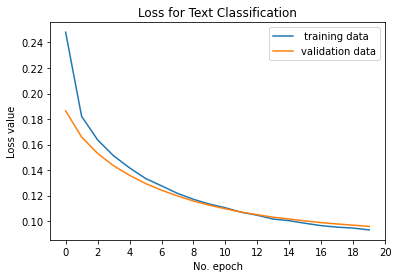

In [ ]:

plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.xticks(np.linspace(0, 20, 11))
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

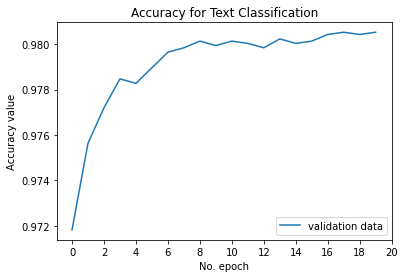

In [ ]:
plt.plot(history.history['val_accuracy'], label='validation data')
plt.xticks(np.linspace(0, 20, 11))
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

In [ ]:

y_pred_keras = model.predict_proba(x_valid)
y_pred_keras = y_pred_keras[:, 1]

print(y_pred_keras)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


[0.98 0.08 0.06 ... 0.06 0.96 0.92]


In [ ]:
s=label1_valid
print(s)

[1 0 0 ... 0 1 1]


Best Threshold=0.467496, G-Mean=0.981
AUC=0.998602


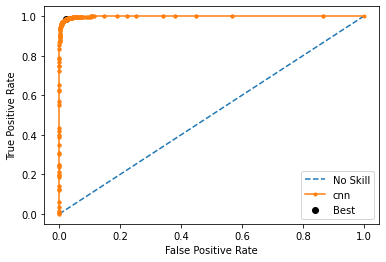

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = roc_curve(s, y_pred_keras)
roc_auc = metrics.auc(fpr, tpr)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
print('AUC=%f'% (roc_auc))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='cnn')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
cnf_matrix = confusion_matrix(s, y_pred_keras.round())
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[5012   98]
 [ 101 5009]]


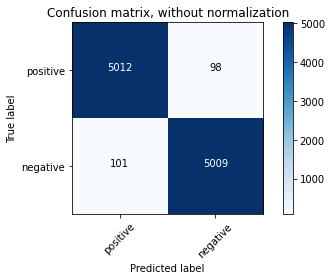

In [ ]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['positive','negative'],
                      title='Confusion matrix, without normalization')

In [ ]:
tn, fp, fn, tp = confusion_matrix(s, y_pred_keras.round()).ravel()
print(y_pred_keras.round())
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

[1. 0. 0. ... 0. 1. 1.]
True Negatives:  5012
False Positives:  98
False Negatives:  101
True Positives:  5009


In [ ]:
new_model = tf.keras.models.load_model('/content/gdrive/My Drive/model.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 24, 300)           14126700  
_________________________________________________________________
conv1d (Conv1D)              (None, 23, 128)           76928     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 14,203,886
Trainable params: 77,186
Non-trainable params: 14,126,700
_________________________________________________________________


In [ ]:
print("Generate predictions for all samples")
y_pred = (model.predict_proba(x_valid) >= 0.467496).astype(int)
y_pred = y_pred.argmax(axis=1)
print(y_pred)

Generate predictions for all samples


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


[1 0 0 ... 0 1 1]


In [ ]:
y_pred = np.where((y_pred == 0),'negative',y_pred)
y_pred = np.where((y_pred == '1'),'positive',y_pred)
s = np.where((s == '0'),'negative',s)
s = np.where((s == '1'),'positive',s)
print(y_pred)
print(s)

['positive' 'negative' 'negative' ... 'negative' 'positive' 'positive']
['positive' 'negative' 'negative' ... 'negative' 'positive' 'positive']


In [ ]:
y_test = s.tolist()
y_pred = y_pred.tolist()

In [ ]:
labels=['negative','positive']
print(classification_report(y_test,y_pred,
                            labels=labels))

              precision    recall  f1-score   support

    negative       0.97      0.99      0.98      5110
    positive       0.99      0.97      0.98      5110

    accuracy                           0.98     10220
   macro avg       0.98      0.98      0.98     10220
weighted avg       0.98      0.98      0.98     10220

